# Supermasks in Superposition: Training and Task Inference

<img src="images/teaser_supsup.png">

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F

import torchvision
import numpy as np
import math

from tqdm.notebook import tqdm

## Training

We train our model using the procedure from "What's Hidden in a Randomly Weighted Neural Network" (Ramanujan et al. 2019). Below is a modification of the layers (using signed constant initialization) from this paper for our continual learning setup. As a deviation from this setup, we assume that an edge (u, v) is included in the subnetwork if its score is greater than 0, rather than use it's absolute magnitude to construct a threshold. 

In [9]:
# Subnetwork forward from hidden networks
class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores):
        return (scores >= 0).float()

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g


def mask_init(module):
    scores = torch.Tensor(module.weight.size())
    nn.init.kaiming_uniform_(scores, a=math.sqrt(5))
    return scores


def signed_constant(module):
    fan = nn.init._calculate_correct_fan(module.weight, 'fan_in')
    gain = nn.init.calculate_gain('relu')
    std = gain / math.sqrt(fan)
    module.weight.data = module.weight.data.sign() * std


class MultitaskMaskLinear(nn.Linear):
    def __init__(self, *args, num_tasks=1, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_tasks = num_tasks
        self.scores = nn.ParameterList(
            [
                nn.Parameter(mask_init(self))
                for _ in range(num_tasks)
            ]
        )
        
        # Keep weights untrained
        self.weight.requires_grad = False
        signed_constant(self)
    
    @torch.no_grad()
    def cache_masks(self):
        self.register_buffer(
            "stacked",
            torch.stack(
                [
                    GetSubnet.apply(self.scores[j])
                    for j in range(self.num_tasks)
                ]
            ),
        )

    def forward(self, x):
        if self.task < 0:
            # Superimposed forward pass
            alpha_weights = self.alphas[: self.num_tasks_learned]
            idxs = (alpha_weights > 0).squeeze().view(self.num_tasks_learned)
            if len(idxs.shape) == 0:
                idxs = idxs.view(1)
            subnet = (
                alpha_weights[idxs]
                * self.stacked[: self.num_tasks_learned][idxs]
            ).sum(dim=0)
        else:
            # Subnet forward pass (given task info in self.task)
            subnet = GetSubnet.apply(self.scores[self.task])
        w = self.weight * subnet
        x = F.linear(x, w, self.bias)
        return x


    def __repr__(self):
        return f"MultitaskMaskLinear({self.in_dims}, {self.out_dims})"

In [3]:
# Utility functions
def set_model_task(model, task, verbose=True):
    for n, m in model.named_modules():
        if isinstance(m, MultitaskMaskLinear):
            if verbose:
                print(f"=> Set task of {n} to {task}")
            m.task = task

def cache_masks(model):
    for n, m in model.named_modules():
        if isinstance(m, MultitaskMaskLinear):
            print(f"=> Caching mask state for {n}")
            m.cache_masks()

def set_num_tasks_learned(model, num_tasks_learned):
    for n, m in model.named_modules():
        if isinstance(m, MultitaskMaskLinear):
            print(f"=> Setting learned tasks of {n} to {num_tasks_learned}")
            m.num_tasks_learned = num_tasks_learned

def set_alphas(model, alphas, verbose=True):
    for n, m in model.named_modules():
        if isinstance(m, MultitaskMaskLinear):
            if verbose:
                print(f"=> Setting alphas for {n}")
            m.alphas = alphas

## Model

For simplicity we use a simple 3-layer fully connected neural network. Note that you can make any neural by replacing a standard layer with its corresponding mask layer.

In [21]:
# Multitask Model, a simple fully connected model in this case
class MultitaskFC(nn.Module):
    def __init__(self, hidden_size, num_tasks):
        super().__init__()
        self.model = nn.Sequential(
            MultitaskMaskLinear(
                784,
                hidden_size,
                num_tasks=num_tasks,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                hidden_size,
                num_tasks=num_tasks,
                bias=False
            ),
            nn.ReLU(),
            MultitaskMaskLinear(
                hidden_size,
                100,
                num_tasks=num_tasks,
                bias=False
            )
        )
    
    def forward(self, x):
        return self.model(x.flatten(1))

## Dataset 

Our "base" dataset is MNIST. Each task is a random permutation of the pixels of MNIST. Namely, given a dataset $\{(x_i, y_i)\}_i$ for each task $t$, we take a random permutation $S^t\in S_{784}$ and construct a dataset $\{(S^t(x_i), y_i)\}_i$. 

Below we show this process and an example of a particular task. `MNISTPerm` uses an update task method to generate a particular sub-task. To assure these splits are reproducible, `MNISTPerm` takes a `seed` argument. In our paper we evaluate on seeds 0 through 4.

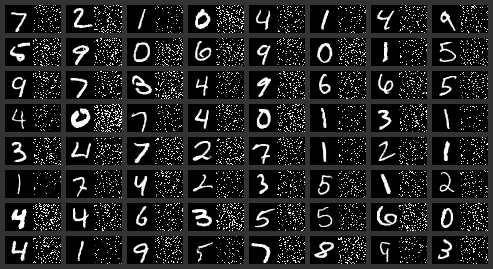

In [5]:
class MNISTPerm:
    class permute(object):
        def __call__(self, tensor):
            out = tensor.flatten()
            out = out[self.perm]
            return out.view(1, 28, 28)

        def __repr__(self):
            return self.__class__.__name__

    def __init__(self, seed=0):
        super(MNISTPerm, self).__init__()
        
        data_root = "mnist"
        self.permuter = self.permute()
        self.seed = seed
        train_dataset = torchvision.datasets.MNIST(
            data_root,
            train=True,
            download=True,
            transform=torchvision.transforms.Compose(
                [
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                    self.permuter,
                ]
            ),
        )

        # Data loading code
        self.train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=128, shuffle=True
        )
        self.val_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(
                data_root,
                train=False,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                        self.permuter,
                    ]
                ),
            ),
            batch_size=128,
            shuffle=False,
        )

    def update_task(self, i):
        np.random.seed(i + self.seed)
        self.permuter.__setattr__("perm", np.random.permutation(784))
    
    def unpermute(self):
        self.permuter.__setattr__("perm", np.arange(784))

mnist = MNISTPerm()

# Showing some example images from MNISTPerm
mnist.unpermute()
batch, labels = next(iter(mnist.val_loader))

mnist.update_task(0)
task0, labels = next(iter(mnist.val_loader))

torchvision.transforms.ToPILImage()(
    torchvision.utils.make_grid(
        torch.cat([batch, task0], dim=-1)[:64],
        normalize=True,
        padding=5,
        pad_value=0.2
    )
)

### Simple train and evaluation loops for classification

In [6]:
# Finding supermasks per task

def train(model, trainloader, optimizer, epoch):
    model.train()

    criterion = nn.CrossEntropyLoss()
    num_correct = 0
    total_seen = 0
    for i, (batch, labels) in tqdm(
        enumerate(trainloader),
        ascii=True,
        total=len(trainloader)
    ):
        logits = model(batch)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 20 == 0:
            predictions = logits.argmax(dim=-1)
            num_correct += (predictions == labels).float().sum()
            total_seen += logits.size(0) 
            tqdm.write(
                (f"e{epoch} {i+1}/{len(trainloader)}"
                f" => Loss {loss.item():0.4f}, "
                f"Acc@1 {(num_correct / total_seen):0.4f}"),
                end="\r"
            )


@torch.no_grad()
def evaluate(model, val_loader, epoch):
    model.eval()
    num_correct = 0
    total_seen = 0
    for batch, labels in tqdm(
        val_loader,
        ascii=True,
        total=len(val_loader)
    ):
        logits = model(batch)
        predictions = logits.argmax(dim=-1)
        num_correct += (predictions == labels).float().sum()
        total_seen += logits.size(0) 
    

    tqdm.write(
        f"Val Perf after {epoch + 1} epochs "
        f"Acc@1 {(num_correct / total_seen):0.4f}", 
    )
    return num_correct / total_seen



For any scenario where task ID is given during train time, we simply train each supermask independently, one per task. We make use of our utility function `set_model_task` to do this. We use 5 tasks for demonstration purposes. Feel free to increase `num_tasks` in the following cell. In our paper we use as many as 2500 tasks with no drop in performance for either task inference or validation accuracy.

In [22]:
# Task ID given during train time
from IPython.display import clear_output

num_tasks = 5 # For demonstration purposes, we go up to 2500 in our paper
model = MultitaskFC(hidden_size=300, num_tasks=num_tasks)

for task in range(num_tasks):
    print(f"Training for task {task}")
    set_model_task(model, task)
    mnist.update_task(task)

    optimizer = optim.RMSprop([p for p in model.parameters() if p.requires_grad], lr=1e-4)
    # Train for 1 epoch
    for e in range(1):
        train(model, mnist.train_loader, optimizer, e)
        
        print("Validation")
        print("============")
        acc1 = evaluate(model, mnist.val_loader, e)
        
    
    cache_masks(model)
    print()
    set_num_tasks_learned(model, task + 1)
    print()

Training for task 0
=> Set task of model.0 to 0
=> Set task of model.2 to 0
=> Set task of model.4 to 0


e0 461/469 => Loss 0.2461, Acc@1 0.8532
Validation



Val Perf after 1 epochs Acc@1 0.9191
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 1
=> Setting learned tasks of model.2 to 1
=> Setting learned tasks of model.4 to 1

Training for task 1
=> Set task of model.0 to 1
=> Set task of model.2 to 1
=> Set task of model.4 to 1


e0 461/469 => Loss 0.2363, Acc@1 0.8506
Validation



Val Perf after 1 epochs Acc@1 0.9292
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 2
=> Setting learned tasks of model.2 to 2
=> Setting learned tasks of model.4 to 2

Training for task 2
=> Set task of model.0 to 2
=> Set task of model.2 to 2
=> Set task of model.4 to 2


e0 461/469 => Loss 0.2814, Acc@1 0.8574
Validation



Val Perf after 1 epochs Acc@1 0.9225
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 3
=> Setting learned tasks of model.2 to 3
=> Setting learned tasks of model.4 to 3

Training for task 3
=> Set task of model.0 to 3
=> Set task of model.2 to 3
=> Set task of model.4 to 3


e0 461/469 => Loss 0.2601, Acc@1 0.8496
Validation



Val Perf after 1 epochs Acc@1 0.9207
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 4
=> Setting learned tasks of model.2 to 4
=> Setting learned tasks of model.4 to 4

Training for task 4
=> Set task of model.0 to 4
=> Set task of model.2 to 4
=> Set task of model.4 to 4


e0 461/469 => Loss 0.2476, Acc@1 0.8669
Validation



Val Perf after 1 epochs Acc@1 0.9269
=> Caching mask state for model.0
=> Caching mask state for model.2
=> Caching mask state for model.4

=> Setting learned tasks of model.0 to 5
=> Setting learned tasks of model.2 to 5
=> Setting learned tasks of model.4 to 5



## Inference

### Scenario GG: Task ID is given at train time and inference time

If task ID is given at inference time, we simply evaluate using the mask we have trained for that ID. This procedure is shown below.

In [27]:
# When task ID we can simply set the mask and evaluate

gg_performance = []
for task in range(5):
    set_model_task(model, task)
    mnist.update_task(task)
    acc1 = evaluate(model, mnist.val_loader, 0)
    gg_performance.append(acc1.item())

clear_output()
    
print(f"Average top 1 performance: {(sum(gg_performance) / len(gg_performance)):.4f}")

print("Per task performance")
for t in range(5):
    print(f"Task {t}: {gg_performance[t]:.4f}")

=> Average top 1 performance: 0.9237
Per task performance
Task 0: 0.9191
Task 1: 0.9292
Task 2: 0.9225
Task 3: 0.9207
Task 4: 0.9269


### Scenario GNs: Task ID is given at train time but not inference time

We can infer task identity at inference time for arbitrary pieces of data. Here we use the one-shot algorithm described in the paper for simplicity. In short, we assign each learned supermask $M^i$ a weight $\alpha_i$ such that $\sum_{i} \alpha_i = 1$ and $\alpha_i >= 0$. 

Given an example data point $x$ to classify, we can compute our loss as $H = \mathcal{H}\left(f\left(x, \theta \odot \left(\sum_i \alpha_i M^i\right)\right)\right)$ where $f(x, \theta)$ is our neural network which outputs logits and $\mathcal H$ is our entropy function. From here our inferred task is simply 
$$t = \text{argmin}_i \frac{\partial\mathcal{H}}{\partial \alpha_i}.$$

#### Intuition

We can see entropy as a measure of confidence in our prediction. High entropy prediction distributions are very uncertain (close to uniform) and lowest entropy is reached when our distribution is very certain (at a one hot vector). So it stands to reason that supermasks which haven't been trained on the exemplar data will have high entropy. Further, instead of showing each individual supermask $x$, which would be computationally intractible for many tasks, we can show $x$ to a _superposition_ of supermasks and optimize for superposition coefficients $\alpha_i$. Choosing the smallest $\alpha_i$ for our task is essentially greedily moving in the direction of maximal decrease in entropy. 

Below is a simple implementation of oneshot task inference.

In [12]:
# When task info is not provided we can infer it
# here we use the oneshot task inference alg detailed in the paper

def oneshot_task_inference(model, batch, num_tasks):
    # Set task < 0 for inference mode
    set_model_task(model, -1, verbose=False)
    
    # Initialize alphas to uniform
    alphas = torch.ones(num_tasks, 1, 1) / num_tasks
    alphas.requires_grad_(True)
    set_alphas(model, alphas, verbose=False)
    
    logits = model(batch)
    
    # Entropy of logits
    entropy = -(logits.softmax(dim=1) * logits.log_softmax(dim=1)).sum(1).mean()
    
    # Gradient wrt alphas
    g, = autograd.grad(entropy, alphas)
    
    inferred_task = (-g).squeeze().argmax()

    return inferred_task.item()

#### Task inference accuracy

Below we show how accurate task inference is using our oneshot algorithm. If you would like to evaluate on more tasks (we use 5 for demonstration), just modify the `num_tasks` variable in the cell where we declare `MultitaskFC`. 

Here we evaluate task inference on 50 random images per task (the `trials` variable modifies this number) and show we predict the correct task with 100% accuracy. 

In [30]:
# How many examples to show for task inference
num_examples = 1
trials = 50
num_correct = 0
num_seen = 0
for _ in tqdm(range(trials)):
    for task in range(5):
        mnist.update_task(task)
        inferred_task = oneshot_task_inference(
            model,
            batch=next(iter(mnist.val_loader))[0][:num_examples],
            num_tasks=5
        )
        if inferred_task == task:
            num_correct += 1
        num_seen += 1

print(f"Task inference accuracy: {100 * num_correct / num_seen}%")


Task inference accuracy: 100.0%


#### Full inference procedure

Below is an example of how this could be used in an inference pipeline. In this scenario, we use one random image from the validation set to infer task identity $t$ and then evaluate with the appropriate mask $M^t$ on all tasks. We see that there is no drop in performance from the GG scenario. 

Note that for simplicity this is a small deviation from the evaluation setup in our paper. In our paper we use 1 image per batch to determine the task identity of the batch, and evaluate that batch using the inferred task. So task inference needs to be correct more often to match GG performance. We have already shown task inference accuracy is 100% with high probability in the previous cell so we don't need to do that here. 

In [31]:
# Evaluation

num_examples = 1

# After task inference, we just perform the same evaluation procedure as before
gns_performance = []
for task in range(5):
    mnist.update_task(task)
    inferred_task = oneshot_task_inference(
        model,
        batch=next(iter(mnist.val_loader))[0][:num_examples],
        num_tasks=5
    )
    set_model_task(model, inferred_task)
    acc1 = evaluate(model, mnist.val_loader, 0)
    gns_performance.append(acc1.item())

clear_output()
avg_acc = (sum(gns_performance) / len(gns_performance))
print(f"=> Average top 1 performance: {100*avg_acc:.4f}%")
print(f"=> Difference from GG performance: "
      f"{(sum(gg_performance) / len(gg_performance) - avg_acc):.4f}")

=> Average top 1 performance: 92.3680%
=> Difference from GG performance: 0.0000


In [19]:
print(torch.__version__)

1.5.1
